In [131]:
import pickle

import matplotlib.pyplot as plt
import mplcursors
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the data

In [132]:
import os
from config import DATA_DIR

# data = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
data = pd.read_csv(os.path.join(DATA_DIR, "train_data_cleaned.csv"))

# Explore the data

In [133]:
print(data.head())

                            Наименование  2022-01-10  2022-01-14  2022-01-21  \
0                   Аллохол, 50 таблеток       99.83      100.21      100.09   
1                             Бананы, кг      104.55      101.13      101.32   
2  Баранина (кроме бескостного мяса), кг      100.25      100.04      100.42   
3                   Бензин автомобильный      100.52      100.06      100.14   
4    Бензин автомобильный марки АИ-92, л      100.51      100.06      100.11   

   2022-01-28  2022-02-04  2022-02-11  2022-02-18  2022-02-25  2022-03-04  \
0       99.79       99.46       99.95       99.96      100.66      102.67   
1      101.76      101.81      102.35      102.20      102.80      107.20   
2      100.32       99.93      100.20      100.36      100.22      100.22   
3      100.18      100.02      100.04      100.06      100.00      100.04   
4      100.17       99.92      100.04      100.06       99.98      100.00   

   ...  2024-05-02  2024-05-06  2024-05-13  2024-05-20  

In [134]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Columns: 129 entries, Наименование to 2024-07-01
dtypes: float64(128), object(1)
memory usage: 102.9+ KB
None


In [135]:
print(data.describe())

       2022-01-10  2022-01-14  2022-01-21  2022-01-28  2022-02-04  2022-02-11  \
count  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000   
mean   100.922549  100.161863  100.287745  100.262745  100.332941  100.286863   
std      1.962619    0.438166    0.470066    0.458089    0.649273    0.552875   
min     99.570000   98.860000   98.680000   98.980000   99.270000   99.530000   
25%    100.012500   99.962500  100.020000  100.000000  100.000000  100.000000   
50%    100.300000  100.090000  100.190000  100.200000  100.230000  100.170000   
75%    100.685000  100.300000  100.490000  100.385000  100.500000  100.450000   
max    108.910000  102.110000  102.700000  102.690000  104.200000  102.640000   

       2022-02-18  2022-02-25  2022-03-04  2022-03-11  ...  2024-05-02  \
count  102.000000  102.000000  102.000000  102.000000  ...  102.000000   
mean   100.331961  100.474216  101.853431  102.237451  ...  100.242745   
std      0.502993    0.781671    3.316733    2.7

# Clean and transform the data

In [136]:
# Handle missing values if any
data = data.dropna()

# Extract product names and dates
product_names = data.iloc[:, 0]
price_data = data.iloc[:, 1:]

# Convert the price data to a long format
price_data_long = pd.melt(data, id_vars=['Наименование'], var_name='Date', value_name='Price')

# Rename columns for clarity
price_data_long.columns = ['Product', 'Date', 'Price']

# Convert Date column to datetime format
price_data_long['Date'] = pd.to_datetime(price_data_long['Date'], format='%Y-%m-%d')

# Convert Price column to numeric, forcing errors to NaN
price_data_long['Price'] = pd.to_numeric(price_data_long['Price'], errors='coerce')

# Drop rows with NaN values in Price column
price_data_long = price_data_long.dropna(subset=['Price'])

print(price_data_long.head())
print(price_data_long.tail())

# DEBUG
filename = os.path.join(DATA_DIR, "price_data_long.csv")
price_data_long.to_csv(filename, index=False)

                                 Product       Date   Price
0                   Аллохол, 50 таблеток 2022-01-10   99.83
1                             Бананы, кг 2022-01-10  104.55
2  Баранина (кроме бескостного мяса), кг 2022-01-10  100.25
3                   Бензин автомобильный 2022-01-10  100.52
4    Бензин автомобильный марки АИ-92, л 2022-01-10  100.51
                             Product       Date   Price
13051              Щетка зубная, шт. 2024-07-01   99.96
13052  Электропылесос напольный, шт. 2024-07-01   99.30
13053         Эргоферон, 20 таблеток 2024-07-01   99.57
13054                     Яблоки, кг 2024-07-01  101.54
13055           Яйца куриные, 10 шт. 2024-07-01   99.01


# Preliminary analysis

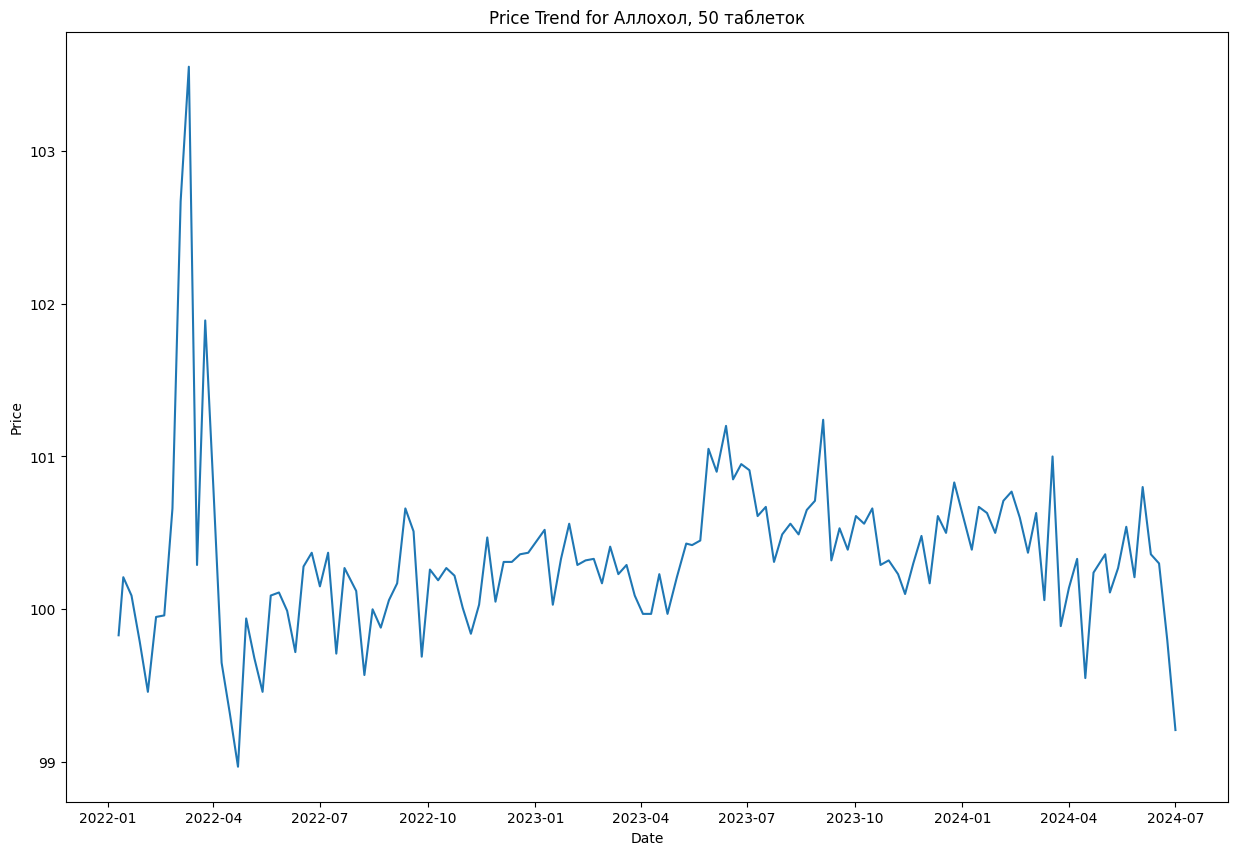

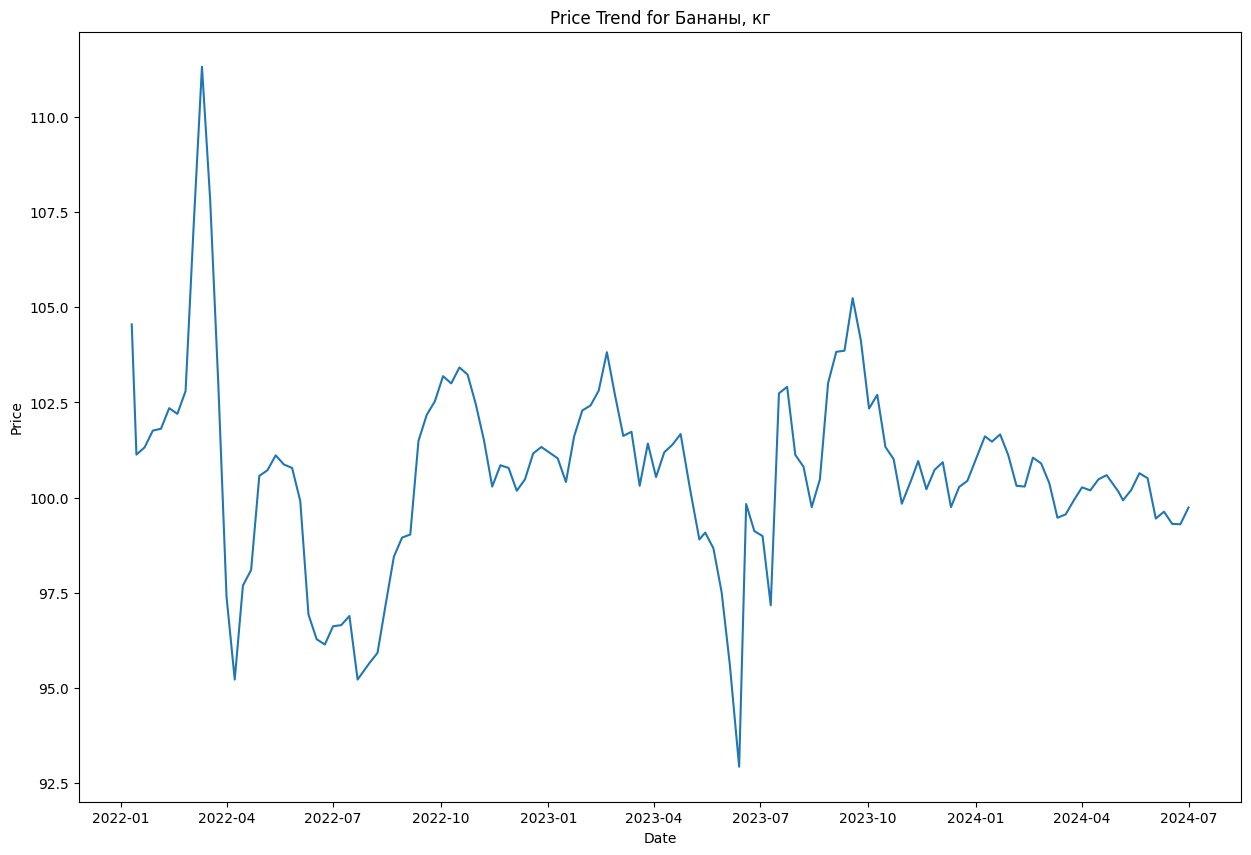

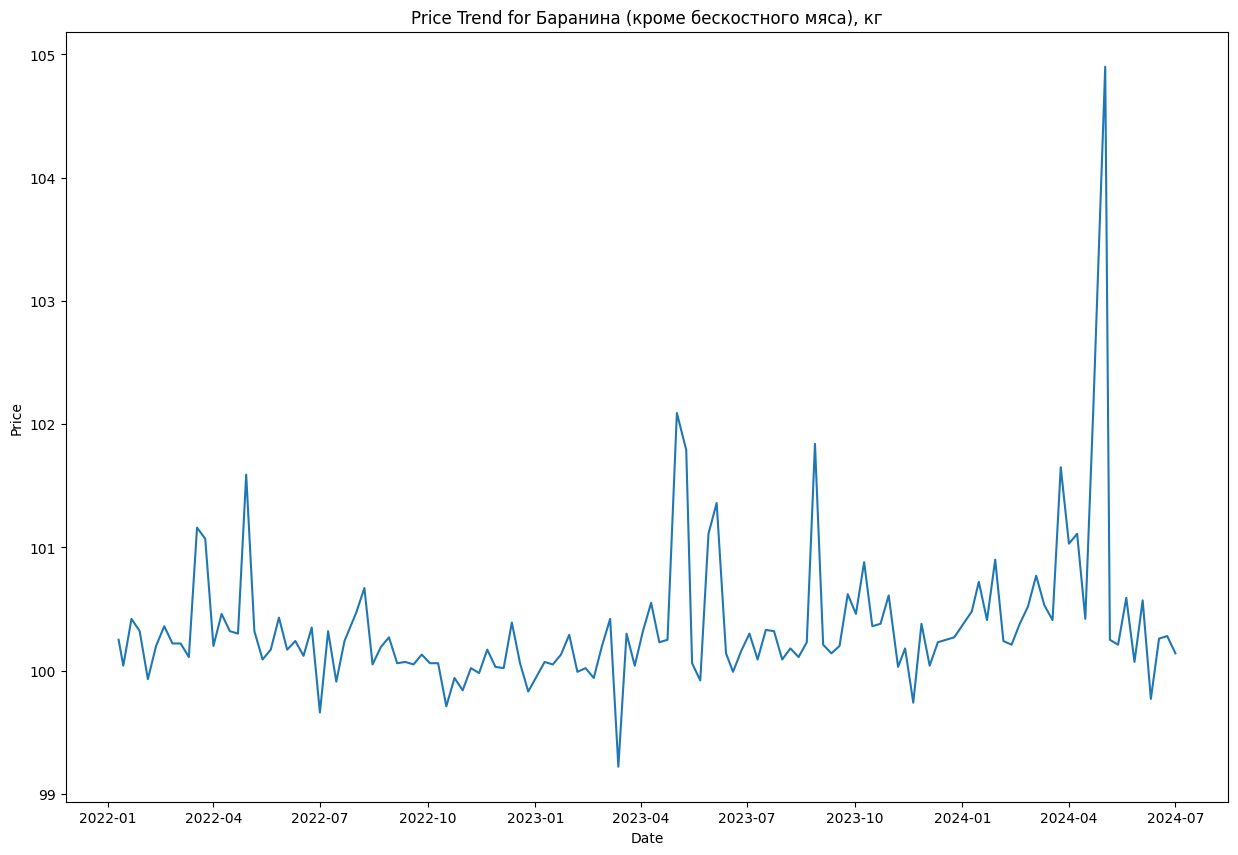

In [137]:
# Plot price trends for each product
for product in price_data_long['Product'].unique()[:3]:
    product_data = price_data_long[price_data_long['Product'] == product]
    plt.figure(figsize=(15, 10))
    plt.plot(product_data['Date'], product_data['Price'])
    plt.title(f'Price Trend for {product}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

# Train-test split ???????????????????

In [138]:
# Split the data into training and testing sets
train_data = price_data_long[price_data_long['Date'] <= '2024-01-09']
test_data = price_data_long[price_data_long['Date'] > '2024-01-09']

# train_data = price_data_long[price_data_long['Date'] < '2022-01-21']
# test_data = price_data_long[price_data_long['Date'] >= '2022-01-21']

In [139]:
print("Train data:")
print(train_data.head())
print(train_data.tail())

filename = os.path.join(DATA_DIR, "train.csv")
train_data.to_csv(filename)

Train data:
                                 Product       Date   Price
0                   Аллохол, 50 таблеток 2022-01-10   99.83
1                             Бананы, кг 2022-01-10  104.55
2  Баранина (кроме бескостного мяса), кг 2022-01-10  100.25
3                   Бензин автомобильный 2022-01-10  100.52
4    Бензин автомобильный марки АИ-92, л 2022-01-10  100.51
                             Product       Date   Price
10501              Щетка зубная, шт. 2024-01-09  100.21
10502  Электропылесос напольный, шт. 2024-01-09   99.59
10503         Эргоферон, 20 таблеток 2024-01-09  100.28
10504                     Яблоки, кг 2024-01-09  101.79
10505           Яйца куриные, 10 шт. 2024-01-09  100.78


In [140]:
print("Test data:")
print(test_data.head())
print(test_data.tail())

filename = os.path.join(DATA_DIR, "test.csv")
test_data.to_csv(filename)

Test data:
                                     Product       Date   Price
10506                   Аллохол, 50 таблеток 2024-01-15  100.67
10507                             Бананы, кг 2024-01-15  101.47
10508  Баранина (кроме бескостного мяса), кг 2024-01-15  100.72
10509                   Бензин автомобильный 2024-01-15  100.02
10510    Бензин автомобильный марки АИ-92, л 2024-01-15  100.02
                             Product       Date   Price
13051              Щетка зубная, шт. 2024-07-01   99.96
13052  Электропылесос напольный, шт. 2024-07-01   99.30
13053         Эргоферон, 20 таблеток 2024-07-01   99.57
13054                     Яблоки, кг 2024-07-01  101.54
13055           Яйца куриные, 10 шт. 2024-07-01   99.01


# Build and train the model

In [141]:
# # Select one product for demonstration
# product_name = "Аллохол, 50 таблеток"
# product_train_data = train_data[train_data['Product'] == product_name]
# product_test_data = test_data[test_data['Product'] == product_name]
# 
# # Sort the data by date
# product_train_data = product_train_data.sort_values(by='Date')
# product_test_data = product_test_data.sort_values(by='Date')
# 
# # Build the model
# model = ExponentialSmoothing(product_train_data['Price'], trend='add', seasonal='add', seasonal_periods=3)
# model_fit = model.fit()
# 
# # Forecast for the test period
# forecast = model_fit.forecast(steps=len(product_test_data))
# 
# # Convert forecast to a DataFrame for easy comparison
# forecast_df = pd.DataFrame({'Date': product_test_data['Date'], 'Forecast': forecast})
# 
# # Plot actual vs forecast
# plt.figure(figsize=(14, 7))
# plt.plot(product_train_data['Date'], product_train_data['Price'], label='Train')
# plt.plot(product_test_data['Date'], product_test_data['Price'], label='Test')
# plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
# plt.legend()
# plt.title(f'Forecast for {product_name}')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.grid(True)
# # Add more details and a grid to the plot
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


# Evaluate model

In [142]:
# # Calculate evaluation metrics (e.g., Mean Absolute Error)
# from sklearn.metrics import mean_absolute_error
# 
# mae = mean_absolute_error(product_test_data['Price'], forecast)
# print(f'Mean Absolute Error for {product_name}: {mae}')


In [143]:
products = train_data["Product"]

product_name = products[1]
product_train_data = train_data[train_data['Product'] == product_name]
product_test_data = test_data[test_data['Product'] == product_name]

# Sort the data by date
product_train_data = product_train_data.sort_values(by='Date')
product_test_data = product_test_data.sort_values(by='Date')

print(f"Plotting for {product_name}")

Plotting for Бананы, кг


# Forecast for the Next 6 Months

/home/artur/dev/cpi-forecast-service/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/artur/dev/cpi-forecast-service/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In-sample Mean Absolute Error: 0.9804915864795266
In-sample Percentage Mean Absolute Error: 0.97%


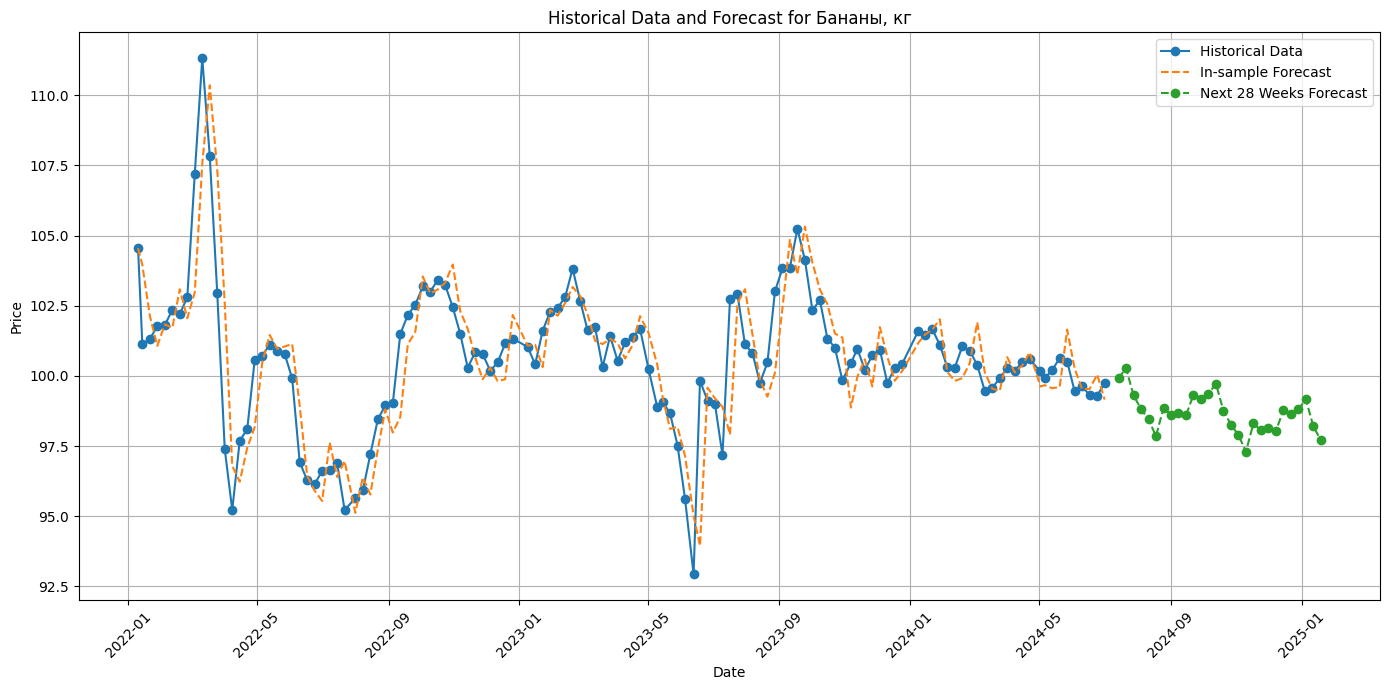

In [144]:
# Combine train and test data for plotting
combined_data = pd.concat([product_train_data, product_test_data]).sort_values(by='Date')

# Build the model
model = ExponentialSmoothing(combined_data['Price'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Save the model to a file
model_filename = f"{product_name.replace(' ', '_')}_model.pkl"
model_path = os.path.join(DATA_DIR, "trained_models", model_filename)
with open(model_filename, 'wb') as f:
    pickle.dump(model_fit, f)

# Forecast for the next 28 weeks
forecast_horizon = 28
forecast_dates = pd.date_range(start=combined_data['Date'].max() + pd.Timedelta(days=7), periods=forecast_horizon,
                               freq='W')
forecast = model_fit.forecast(steps=forecast_horizon)

# Calculate evaluation metrics
actual = combined_data["Price"]
in_sample_forecast = model_fit.fittedvalues
mae = mean_absolute_error(actual, in_sample_forecast)
print(f"In-sample Mean Absolute Error: {mae}")

# Percentage MAE
percentage_mae = mae / actual.mean() * 100
print(f"In-sample Percentage Mean Absolute Error: {percentage_mae:.2f}%")

# Plot the data and forecast
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(combined_data['Date'], combined_data['Price'], label='Historical Data', marker='o')

# Plot in-sample forecast
plt.plot(combined_data['Date'], in_sample_forecast, label='In-sample Forecast', linestyle='--')

# Plot out-of-sample forecast
plt.plot(forecast_dates, forecast, label='Next 28 Weeks Forecast', linestyle='--', marker='o')

plt.legend()
plt.title(f'Historical Data and Forecast for {product_name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Add more details and a grid to the plot
plt.xticks(rotation=45)
plt.tight_layout()

# Add zooming capability
mplcursors.cursor(hover=True)

plt.show()